# Process Data

## Load Data

In [68]:
import pandas as pd

PATH = '../Twitter_Climate_Change_Dataset/twitter_sentiment_data.csv'
df = pd.read_csv(PATH, encoding='utf8')
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


Seperate Messages from the rest of the data, for NLP

In [69]:
sMessages = df['message']

## Plot Data

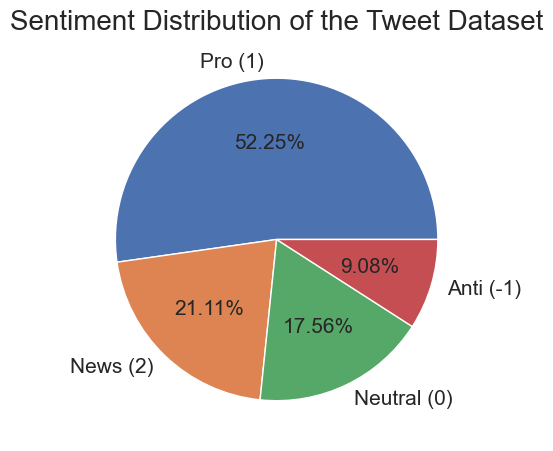

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 5))
plt.pie(df.sentiment.value_counts().values, labels = ['Pro (1)', 'News (2)', 'Neutral (0)', 'Anti (-1)'], autopct = '%.2f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()

# Pre-Processing

## Data Cleaning

Tweets often times have a lot of content that is not important for the meaning of the Tweet but rather for its operation within Twitter. Those can be things like the retweet-symbol ("RT") or the authors username. Those informations could be unimportant and there might want to be removed.
Things that will be removed by this function:
- Retweet-markers (The part of the tweet that looks like 'RT @Username: [...]')
- Twitter usernames (The part of the tweet that looks like '[...] @username [...]')

Hashtags will NOT be removed since they can hold important information about the content and sentiment of the tweet.

In [71]:
import re 

def removeTwitterContent(text):
    '''
    Clean the Text of ReTweet-symbols and usernames
    '''
    rt_removed_text = re.sub(r'RT @\w+: ', '', text)
    twitter_cleaned_text = re.sub(r'@\w+', '', rt_removed_text)
    return twitter_cleaned_text

Turn all tweets into tokens to handle them with more ease. A Token in this case is defined as a lower-cased word or a single punctuation.

In [72]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

def wordTokens (text):
    '''
    Create a list of lower-cased words and punctuations
    '''
    text = text.lower()
    tokenized_word = word_tokenize(text)
    return tokenized_word

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [73]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

def negationHandle (sentence):
    '''
    Turn negated words into cognitive synonyms. (Source: https://gist.github.com/UtkarshRedd/3fbfd354ea7a6f83bd8f9419a27b0543#file-negation_handler-py ,
    https://towardsdatascience.com/increasing-accuracy-of-sentiment-classification-using-negation-handling-9ed6dca91f53)
    This will turn a list like this: ["I", "don't", "like", "movies"] into -> ["I", "dislike", "movies"]
    '''
    temp = int(0)
    for i in range(len(sentence)):
        # The word after the i-1-th token is negated
        if sentence[i-1] in ['not',"n't"]:
            antonyms = []
            # Get all synset instances belonging to the i-th token
            syns = wordnet.synsets(sentence[i])
            for syn in syns:
                w1 = syns[0].name()
                # Find if there exist antonyms
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                temp = 0
                max_dissimilarity = 0
                # Get the antonym with the highest dissimilarity and then swap the original tokens with the antonym (like: don't like -> dislike)
                for antonym in antonyms:
                    syns = wordnet.synsets(antonym)
                    w2 = syns[0].name()
                    syns = wordnet.synsets(sentence[i])
                    w1 = syns[0].name()
                    word1 = wordnet.synset(w1)
                    word2 = wordnet.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                        # print(word1, word2, temp)
                    if temp > max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = antonym
                        sentence[i] = antonym_max
                        sentence[i-1] = ''
    while '' in sentence:
        sentence.remove('')
    return sentence
antonyms = []
  
negationHandle(["don't", "like"])



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


["don't", 'like']

Remove Stopwords like "and", "the", "in" etc

In [74]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

def removeStopwordsPunctuation(word_list):
    '''
    Clean the text of Stopwords and punctuation
    '''
    punctuation = "".join((string.punctuation, "“„'...«»’"))
    stopPunctRemoved = [word for word in word_list if word not in stopwords.words('english') and word not in punctuation]
    
    return stopPunctRemoved


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmatization

In [75]:
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatizeWords(wordList):
    '''
    Lemmatize the text that is put in
    '''
    lemmatizer = WordNetLemmatizer()

    nltk_tagged = nltk.pos_tag(wordList) 
    pos_tags = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    # print(pos_tags)
    # lemmatizeWordList = [lemmatizer.lemmatize(word, pos=pos_tag) for word, pos_tag in pos_tags]
    lemmatizeWordList = []
    for word, pos_tag in pos_tags:
        if pos_tag is None:
            lemmatizeWordList.append(word)
        else:
            lemmatizeWordList.append(lemmatizer.lemmatize(word=word, pos=pos_tag))
    return lemmatizeWordList
lemmatizeWords(["global", "warming", "stopped", "nominal", "humans", "irresponsible"])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['global', 'warming', 'stop', 'nominal', 'human', 'irresponsible']

### Function calls

In [76]:
sTwitter_cleansed = sMessages.apply(lambda x: removeTwitterContent(x))
tokenized_messages = []
for message in sTwitter_cleansed:
    tokenized_message = wordTokens(message)
    tokenized_messages.append(tokenized_message)
lemma_tokens = [lemmatizeWords(message) for message in tokenized_messages]
stopPunctRemoved_tokens = [removeStopwordsPunctuation(message) for message in lemma_tokens]
pre_processed_messages = [negationHandle(message) for message in stopPunctRemoved_tokens]


In [77]:
def createBigrams (text):
    '''
    Tokenize texts as bigrams. Not Higher because it causes very
    sparse feature vectors.
    '''
    bigrams = list(nltk.bigrams(text))
    return bigrams
print(createBigrams(stopPunctRemoved_tokens[8]))

[('leonardo', 'dicaprio'), ('dicaprio', "'s"), ("'s", 'climate'), ('climate', 'change'), ('change', 'documentary'), ('documentary', 'free'), ('free', 'week'), ('week', 'http'), ('http', '//t.co/itpdz6kceg'), ('//t.co/itpdz6kceg', 'indigenous'), ('indigenous', 'tairp'), ('tairp', 'http'), ('http', '//tã¢â‚¬â¦')]


### Data Plots

Here we flatten the nested lists into a list that contains all the single tokens of all messages. This makes it possible to count how many times a token occures across all the messages.

In [78]:
import itertools

joined_tokens = list(itertools.chain.from_iterable(stopPunctRemoved_tokens))

To gain a overview on how our data looks like, we'll proceed to plot some of the data.

In [79]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plotOccurences(token_list):
    fdist = FreqDist(token_list)
    df_fdist = pd.DataFrame(fdist.items(), columns=['Token', 'Occurences'])
    # fdist.plot(30,cumulative=False)
    # plt.show()
    df_fdist.head()
    sns.set(font_scale = 1.3)
    plt.figure(figsize=(5, 5))
    plt.title("Top 20 Occurrences of Tokens in all messages")
    sns.set_style('darkgrid')
    sns.barplot(x="Occurences", y="Token", data=df_fdist.sort_values('Occurences', ascending=False).head(20), palette="flare")

#### Plot Raw Data

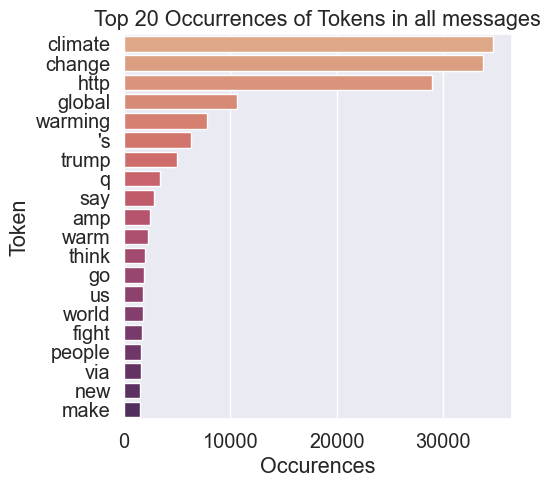

In [80]:
plotOccurences(joined_tokens)

# Feature Engineering

## Bag of Words

In [81]:
"""Transform tokens back to sentence strings"""
cleaned_tweets = []
for tweet in pre_processed_messages:
    sentence  = ' '.join(tweet)
    cleaned_tweets.append(sentence)

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
print(cleaned_tweets[9])
cv.fit(cleaned_tweets)
countVectorizedMessages = cv.transform(cleaned_tweets)

beforetheflood watch beforetheflood right travel world tackle climate change http //t.co/hcizrpuhlf


## Tf-Idf

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(cleaned_tweets)
tfidfVectorizedMessages = tfidf_vectorizer.transform(cleaned_tweets)

# Model Development

In [84]:
from sklearn import metrics

def evaluateModel(model, X_test, y_test, title):
    '''
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    '''
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average='weighted')
    precision = metrics.precision_score(y_test, predictions, average='weighted')
    f1 = metrics.f1_score(y_test, predictions, average='weighted')

    clsScoreDict = {
        "accuracy": accuracy
        , "recall": recall
        , "precision": precision
        , "f1": f1
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

### Split Dataset

In [85]:
from sklearn.model_selection import train_test_split

target = df['sentiment']
X = countVectorizedMessages

X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

## Logistic Regression

In [86]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
clfModel = model.fit(X_train, y_train)
clsScoreDict = evaluateModel(clfModel, X_test, y_test, 'LogisticRegression')


*** LogisticRegression ***
Accuracy:  0.7216457309302748
Precision: 0.7149602997722974
Recall:    0.7216457309302748
F1:        0.714808779676204





c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Support Vector Machines

In [87]:
from sklearn import svm

SVM = svm.SVC()
clfSVM = SVM.fit(X_train, y_train)
SVMScoreDict = evaluateModel(clfSVM, X_test, y_test, 'SVM')


*** SVM ***
Accuracy:  0.7187329328235936
Precision: 0.7255650244696271
Recall:    0.7187329328235936
F1:        0.6971332492958213





## Neural Networks

In [88]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(activation='logistic', hidden_layer_sizes=(7, 7), random_state=1)
clfmlp = mlp.fit(X_train, y_train)
gnbScoreDict = evaluateModel(clfmlp, X_test, y_test, 'mlp')


*** mlp ***
Accuracy:  0.6336246131440014
Precision: 0.6381549114217724
Recall:    0.6336246131440014
F1:        0.6354851482666986





# Demonstration

In [89]:
def preProcessTexts(sText):
    sTwitter_cleansed_test = sText.apply(lambda x: removeTwitterContent(x))
    tokenized_messages_test = []
    for message in sTwitter_cleansed_test:
        tokenized_message = wordTokens(message)
        tokenized_messages_test.append(tokenized_message)
    neg_tokenized_messages_test = [negationHandle(message) for message in tokenized_messages_test]
    stopPunctRemoved_tokens_test = [removeStopwordsPunctuation(message) for message in neg_tokenized_messages_test]
    # LemmaStopPunctRemoved_tokens_test = [lemmatizeWords(message) for message in stopPunctRemoved_tokens_test]

    # Join the tokens of a Tweet back together to form a sentence
    sentences_test = []
    for tweet in stopPunctRemoved_tokens_test:
        sentence  = ' '.join(tweet)
        sentences_test.append(sentence)
    print("Pre-Processed Texts: \n", sentences_test)
    return sentences_test

In [90]:
from pandas import Series

sTestTweets = Series([
    "I believe in climate change. It is definitely caused by humans and I don't like that people try to fight me on my belief!",
    "RT @TrumpVoter: Global warming stopped! It is not real and humans are not responsible! There isn't a man-made climate change",
    "The weather is very cold, I don't believe in that crap. Everybody keeps talking about global warming while it is 12 degrees in Montana",
    "I like the new Spiderman, it changes the climate of the whole industry",
    "Here you can find some great news about climate change: http://www.climate.org",
    "Global warming is not real"])

# Pre-processing and cleaning of Tweets
cleanedTweets = preProcessTexts(sTestTweets)

# Vector to count token occurrences
vectorizedTweets = cv.transform(cleanedTweets)

# Predict lables
clfModel.predict(vectorizedTweets)

Pre-Processed Texts: 
 ['believe climate change definitely caused humans dislike people try fight belief', "global warming stopped nominal humans irresponsible n't man-made climate change", 'weather cold disbelieve crap everybody keeps talking global warming 12 degrees montana', 'like new spiderman changes climate whole industry', 'find great news climate change http //www.climate.org', 'global warming nominal']


array([ 1,  1, -1,  0,  1,  0], dtype=int64)

In [91]:
from pandas import Series

sTestTweets = Series([
    "I believe in climate change. It is definitely caused by humans and I don't like that people try to fight me on my belief!",
    "RT @TrumpVoter: Global warming stopped! It is not real and humans are not responsible! There isn't a man-made climate change"
    ])

# Pre-processing and cleaning of Tweets
cleanedTweets = preProcessTexts(sTestTweets)

# Vector to count token occurrences
vectorizedTweets = cv.transform(cleanedTweets)

# Predict lables
clfModel.predict(vectorizedTweets)

Pre-Processed Texts: 
 ['believe climate change definitely caused humans dislike people try fight belief', "global warming stopped nominal humans irresponsible n't man-made climate change"]


array([1, 1], dtype=int64)

In [92]:
lemmatizeWords(
    removeStopwordsPunctuation(
        negationHandle(
            wordTokens(
                removeTwitterContent(
                    "RT @TrumpVoter: Global warming stopped! It is not real and humans are not responsible! Please focus on change in other areas"
                )
            )
        )
    )
)

['global',
 'warming',
 'stop',
 'nominal',
 'human',
 'irresponsible',
 'please',
 'focus',
 'change',
 'area']

In [93]:

test = cv.transform(["RT @TrumpVoter: Global warming stopped! It is not real and humans are not responsible! Please focus on change in other areas"])
print(len(cv.vocabulary_))
print(test)

53454
  (0, 6536)	1
  (0, 6959)	1
  (0, 10858)	1
  (0, 18547)	1
  (0, 20210)	1
  (0, 22720)	1
  (0, 23822)	1
  (0, 24635)	1
  (0, 24731)	1
  (0, 32634)	1
  (0, 33829)	1
  (0, 34218)	1
  (0, 35869)	1
  (0, 38566)	1
  (0, 39125)	1
  (0, 39940)	1
  (0, 48720)	1


In [94]:
cv2 = CountVectorizer(binary=True)
cv2.fit(df['message'].tolist())
print(len(cv2.vocabulary_))
# Try without news

74991


In [95]:
tfVec = TfidfVectorizer()
tfidf_matrix = tfVec.fit_transform(["Hello my name is james", "This is my python notebook car"])
tfidf_matrix_dense = tfidf_matrix.toarray()
print(tfVec.get_feature_names_out())
print(tfidf_matrix_dense[0])

['car' 'hello' 'is' 'james' 'my' 'name' 'notebook' 'python' 'this']
[0.         0.49922133 0.35520009 0.49922133 0.35520009 0.49922133
 0.         0.         0.        ]


In [96]:
import math

def calculate_tfidf(term, term_frequency, inverse_document_frequencies):
    return term_frequency * inverse_document_frequencies[term]

def calculate_idf(term, documents):
    num_documents = len(documents)
    num_documents_with_term = sum(1 for doc in documents if term in doc)
    return math.log(num_documents / (num_documents_with_term))  if num_documents_with_term != 0 else 0

documents = [
    "This is my example text",
    "This is my python code. I love python"
]

term_frequencies = []
inverse_document_frequencies = {}
unique_terms = set()

# Calculate term frequencies
for document in documents:
    words = document.split()
    term_frequency = {}
    for word in words:
        if word in term_frequency:
            term_frequency[word] += 1
        else:
            term_frequency[word] = 1
        unique_terms.add(word)
    term_frequencies.append(term_frequency)

# Calculate inverse document frequencies
for term in unique_terms:
    inverse_document_frequencies[term] = calculate_idf(term, documents)

# Calculate TF-IDF vectors
tfidf_vectors = []
for term_freq in term_frequencies:
    tfidf_vector = {}
    for term, freq in term_freq.items():
        tfidf_vector[term] = calculate_tfidf(term, freq, inverse_document_frequencies)
    tfidf_vectors.append(tfidf_vector)

# Print TF-IDF vectors for each document
for i, tfidf_vector in enumerate(tfidf_vectors):
    print(f"Document {i+1}:")
    for term, tfidf_score in tfidf_vector.items():
        print(f"Term: {term}, TF-IDF: {tfidf_score}")

Document 1:
Term: This, TF-IDF: 0.0
Term: is, TF-IDF: 0.0
Term: my, TF-IDF: 0.0
Term: example, TF-IDF: 0.6931471805599453
Term: text, TF-IDF: 0.6931471805599453
Document 2:
Term: This, TF-IDF: 0.0
Term: is, TF-IDF: 0.0
Term: my, TF-IDF: 0.0
Term: python, TF-IDF: 1.3862943611198906
Term: code., TF-IDF: 0.6931471805599453
Term: I, TF-IDF: 0.6931471805599453
Term: love, TF-IDF: 0.6931471805599453
